# <center style="background-color:#606F66;color: white; vertical-align: middle; padding:20px 5px;">Aerial Semantic Segmentation Drone </center>

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Importing Libraries</center>

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from keras import layers
import os
from PIL import Image
import math

import imgaug as ia
from imgaug import augmenters

from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle




# <center style="background-color:#54A57C;color: white; vertical-align: middle; padding:10px 5px;">Preprocessing</center>

In [ ]:
def read_and_decode_orginal(filename, reshape_dims):
    
    # 1. Read the file.
    img = tf.io.read_file(filename)
    # 2. Convert the compressed string to a 3D float32 tensor.
    img = tf.io.decode_image( img, channels=3,dtype=tf.dtypes.float32,expand_animations = False)
    # 3. Resize the image to the desired size.

    return tf.image.resize(img, reshape_dims,method='nearest')

def read_and_decode_segmented(filename, reshape_dims,Num_Classes):

    # 1. Read the file.
    img = tf.io.read_file(filename)
    # 2. Convert the compressed string to a 3D int tensor.
    img = tf.io.decode_image( img,channels=1,dtype=tf.dtypes.uint8,expand_animations = False)
    
    img = tf.image.resize(img, reshape_dims,method='nearest')
    img = tf.reshape(img,reshape_dims)

    # 3. Resize the image to the desired size.
    img = tf.one_hot(img, Num_Classes, dtype=tf.uint8)
        
    return img

def decode_csv(combined,orginal_path,segmented_path):
    orginal_img   = read_and_decode_orginal(orginal_path, combined[1])
    segmented_img = read_and_decode_segmented(segmented_path, combined[1],combined[0])
    return orginal_img, segmented_img

In [ ]:
def image_augmentation(image_path,augmentaion_path,pipeline):
    globed=tf.io.gfile.glob(image_path)

    if not os.path.exists(augmentaion_path):
        os.makedirs(augmentaion_path)

    for item in globed:
        

        root,file = os.path.split(item)
        h=os.path.splitext(file)


        image = Image.open(item)
        image = np.array(image)


        ia.seed(1)
        for i,step in enumerate(pipeline):
            temp = step.augment_image(image)

            output_path= os.path.join(augmentaion_path,h[0]+"_"+str(i)+h[1])

            im = Image.fromarray(temp)
            im.save(output_path)
            del im,temp,output_path


In [ ]:
def custom_generator(x_set,y_set,reshape_dims,Num_Classes,batch_sizebatch_size):

    class Custom_Sequence(Sequence):

        def __init__(self, x_set, y_set,reshape_dims,Num_Classes,batch_size):
            self.x, self.y    = x_set, y_set
            self.batch_size   = batch_size
            self.reshape_dims = reshape_dims
            self.Num_Classes  = Num_Classes

        
        def __len__(self):
            return math.ceil(len(self.x) / self.batch_size)

        def __getitem__(self, idx):
            batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

            return np.array([ read_and_decode_orginal(file_name, reshape_dims) for file_name in batch_x]),\
                   np.array([ read_and_decode_segmented(file_name, reshape_dims,Num_Classes) for file_name in batch_y])

    generator = Custom_Sequence(x_set,y_set,reshape_dims,Num_Classes,batch_sizebatch_size)
    
    return generator













def Ready_data( Orginal_path,Mask_path,Orginal_aug,mask_aug , Key_prop,pipeline,split_percent, Augment=False,Batch_dataset=True):
    #file list
    ORIGINAl_LIST = tf.io.gfile.glob(Orginal_path+'*')
    ORIGINAl_LIST.sort()

    Mask_LIST = tf.io.gfile.glob(Mask_path+'*')
    Mask_LIST.sort()

    #augmentaion


    if Augment:
        image_augmentation(ORIGINAl_LIST,Orginal_aug,pipeline)#orginal augmentaion
        image_augmentation(Mask_LIST,mask_aug,pipeline)#mask augmentaion


    ORIGINAL_JPG_LIST_with_aug = tf.io.gfile.glob(Orginal_aug+'/*')
    ORIGINAL_JPG_LIST_with_aug+=ORIGINAl_LIST
    ORIGINAL_JPG_LIST_with_aug.sort()

    Mask_PNG_LIST_with_aug = tf.io.gfile.glob(mask_aug+'/*')
    Mask_PNG_LIST_with_aug+=Mask_LIST
    Mask_PNG_LIST_with_aug.sort()

    index_with_aug = [os.path.splitext(filename)[0].split('/')[-1] for filename in ORIGINAL_JPG_LIST_with_aug]
    index_with_aug.sort()

    # Creating Dataframe from paths
    df=pd.DataFrame((index_with_aug,ORIGINAL_JPG_LIST_with_aug,Mask_PNG_LIST_with_aug)).T
    df.rename(columns = {
        0: 'index',
        1: 'Orginal',
        2: 'Segmented'},

            inplace=True)

    df.set_index('index', inplace= True)

    X_train,X_val = train_test_split(df, test_size=0.2, random_state=42)
    X_val,X_test = train_test_split(X_val, test_size=0.25, random_state=42)
    
    if Batch_dataset:
        #Convert dataframe to tensorflow BatchDataset
        
        Train_DF= (tf.data.Dataset.from_tensor_slices((X_train['Orginal'].values,X_train['Segmented'].values)))
        Train_BatchDataset = (Train_DF.map(partial(decode_csv, Key_prop["combined"]))).batch(Key_prop["batch_size"]).shuffle(3, reshuffle_each_iteration=True)
        
        Eval_DF = (tf.data.Dataset.from_tensor_slices((X_val['Orginal'].values,X_val['Segmented'].values)))
        Eval_BatchDataset  = (Eval_DF.map(partial(decode_csv, Key_prop["combined"]))).batch(Key_prop["batch_size"]).shuffle(3, reshuffle_each_iteration=True)
        
        return Train_BatchDataset ,Eval_BatchDataset ,X_test
    else:
        train_generator = custom_generator(
            X_train['Orginal'].values,
            X_train['Segmented'].values,
            Key_prop["combined"][1],
            Key_prop["combined"][0],
            Key_prop["batch_size"])

        eval_generator = custom_generator(
            X_train['Orginal'].values,
            X_train['Segmented'].values,
            Key_prop["combined"][1],
            Key_prop["combined"][0],
            Key_prop["batch_size"])
        return train_generator,eval_generator,X_test


## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">Preprocessing Paramenters</center>

In [ ]:
Orginal_path = "../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
Mask_path    = "../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"
Orginal_aug  = "../working/Augmentaion/orginal"
Mask_aug     = "../working/Augmentaion/mask"
split_percent=(0.2,0.25)
Key_prop={
    "IMG_HEIGHT"   : 800,
    "IMG_WIDTH"    : 1200,
    "IMG_CHANNELS" : 3,
    "Num_Classes"  : 23,
    "combined":[23,(800, 1200)],
    "batch_size": 16,
    
    
    }

rot_90 = augmenters.Rot90(1,keep_size=False) #rot_90 = augmenters.Rot90(times) #time=1 =>90deg, time=2 =>180deg, time=3 =>270deg
rot_180 = augmenters.Rot90(2,keep_size=False) 
rot_270 = augmenters.Rot90(3,keep_size=False)
flip_hor = augmenters.Fliplr(1) 
fli_vert = augmenters.Flipud(1)

pipeline = [rot_90, rot_180, rot_270, flip_hor, fli_vert]



## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">tensorflow BatchDataset</center>

In [ ]:
#Train_BatchDataset ,Eval_BatchDataset,X_test = Ready_data(
#    Orginal_path,Mask_path,
#    Orginal_aug,Mask_aug,
#    Key_prop,pipeline,
#    split_percent,
#    Augment=False,Batch_dataset=True)

train_generator,eval_generator,X_test = Ready_data(
    Orginal_path,Mask_path,
    Orginal_aug,Mask_aug,
    Key_prop,pipeline,
    split_percent,
    Augment=False,Batch_dataset=False)

In [ ]:
#h=next(iter(Train_BatchDataset))

h=next(iter(train_generator))

2022-06-23 23:56:55.832980: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-23 23:56:55.833030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UB): /proc/driver/nvidia/version does not exist
2022-06-23 23:56:55.837934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


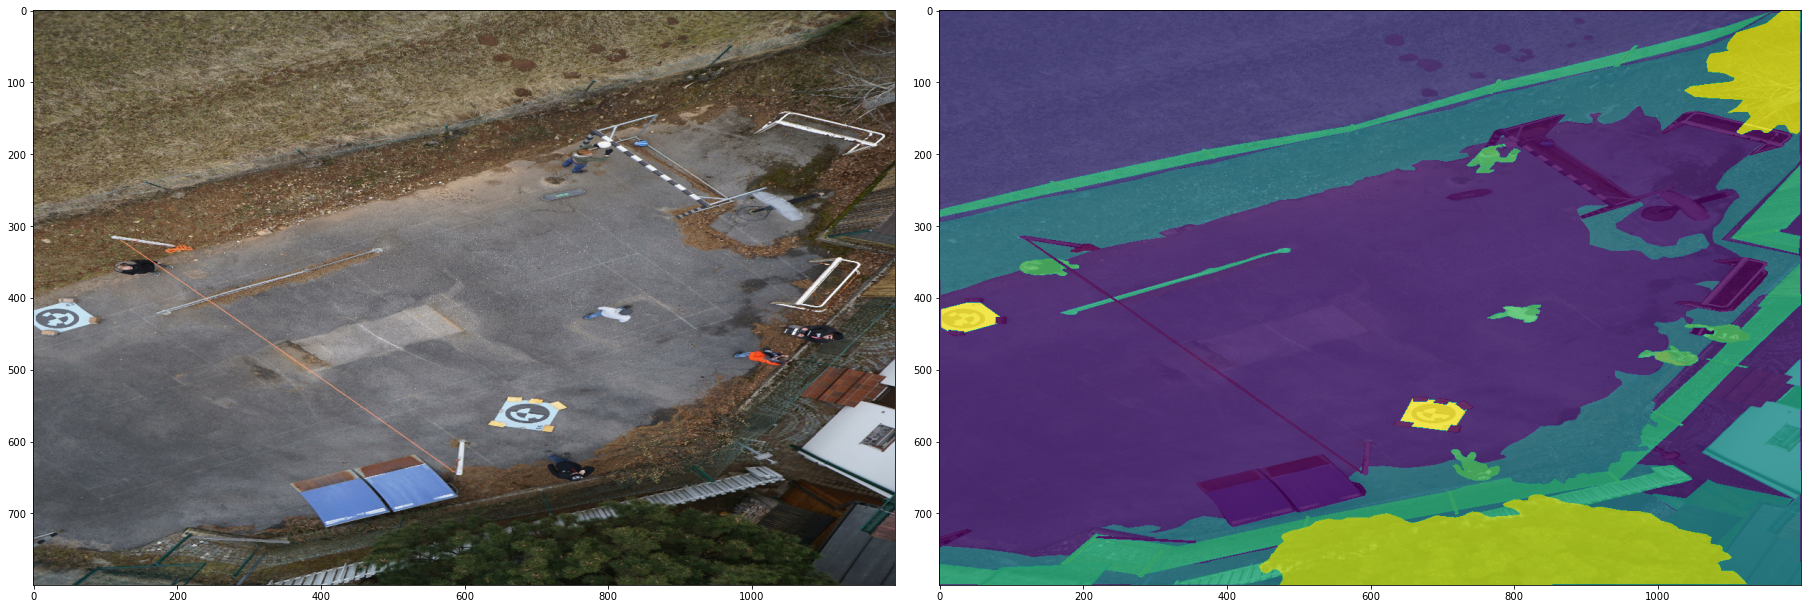

In [ ]:
i=12

fig, axs = plt.subplots(1, 2, figsize=(25, 10), constrained_layout=True)

axs[0].imshow(h[0][i])
axs[0].grid(False)

#axs[1].imshow(h[1][1])
axs[1].grid(False)
axs[1].imshow(h[0][i])
axs[1].imshow(tf.argmax(h[1][i],axis=-1),alpha = 0.8)


# <center style="background-color:#54A57C;color: white; vertical-align: middle; padding:10px 5px;">Model</center>

## <center style="background-color:#EF6145;color: white; vertical-align: middle; padding:10px 5px;">MobileUNet</center>

In [ ]:
from keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Dropout
from keras.layers import concatenate, Conv2D
from keras import callbacks
from keras.models import Model

def multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [ ]:

def Train_model(Model,Train,Val):

    if not ('train_counter' in globals()):
        global train_counter
        train_counter=0
    else:
        train_counter+=1        

    
    
    #callbacks
    reduce_LR = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10, verbose=1, factor=0.5, min_lr=0.000000001)
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True,verbose=0)
    
    weights_file = 'train_run_'+str(train_counter)+'.h5'
    history_file = 'train_run_'+str(train_counter)+'.npy'
    
    #if model is alerady trained load weights and training history
    if os.path.exists(weights_file):
        
        Model.load_weights(weights_file)
        my_history=np.load(history_file,allow_pickle='TRUE').item()

        print('Loaded weights!')
        
    #if not train the model
    else:
        print('training started :) ')

        history_keras =  Model.fit(Train, epochs=200, validation_data=Val,batch_size=16, callbacks=[early_stopping,reduce_LR],verbose=0)

        Model.save_weights(weights_file)
        np.save(history_file,history_keras.history)

        my_history=history_keras.history
        
    return Model,my_history

In [ ]:

model = multi_unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=1200, IMG_CHANNELS=3)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 800, 1200,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 800, 1200, 1  448         ['input_3[0][0]']                
                                6)                                                                
                                                                                                  
 dropout_18 (Dropout)           (None, 800, 1200, 1  0           ['conv2d_38[0][0]']              
                                6)                                                          

In [ ]:

Model,my_history=Train_model(model,train_generator,eval_generator)


training started :) 


2022-06-23 23:29:06.681259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 983040000 exceeds 10% of free system memory.
2022-06-23 23:29:06.681443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1413120000 exceeds 10% of free system memory.
